# Covid-19 분석하기 :)

베이스를 많이 활용하기 보단 보고싶은 것 위주로 하자
- 코로나가 변이하고 난 뒤 연령별 코로나의 위험성 
- 대구 신천지 코로나 이후 대구와 다른지역 비교
- 국내 외 금융관련 주요지표와 코로나의 상관관계

In [4]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import folium
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

import FinanceDataReader as fdr
import pandas_datareader as pdr

import pyecharts
pyecharts.online()
from pyecharts import Line, Bar, Pie, Overlap

import warnings
warnings.filterwarnings('ignore')

# 정규화 라이브러리
from sklearn.preprocessing import MinMaxScaler


plt.rc('font', family='NanumBarunGothic') 

### Data Load
- 기본 베이스 데이터
- 공공기관 데이터 https://www.data.go.kr/index.do
    - age_sex_data = 공공데이터활용지원센터_보건복지부 코로나19 연령별·성별감염 현황
    - current_corona_data = 공공데이터활용지원센터_보건복지부 코로나19 감염 현황
    - city_data = 공공데이터활용지원센터_보건복지부 코로나19 시·도발생 현황
    - city_population_data  = 인구밀집도.csv' (https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007)
        - 인구 : 명/ 1000명
        - 인구 밀도 : 인구수/단위면적
        
하다보니 베이스데이터를 거의 쓰지 않았습니다...


In [5]:
data_path = Path(os.getenv('HOME')+'/aiffel/Hackathon/EDA and Insite/Data')
case_data_path = data_path /'Case.csv'
policy_data_path = data_path / 'Policy.csv'
region_data_path = data_path/ 'Regon.csv'
search_treand_data_path = data_path/'SearchTrend.csv'
seoul_floating_data_path = data_path/'SeoulFloating.csv'
time_data_path = data_path/'Time.csv'
time_age_data_path = data_path/'TimeAge.csv'
time_gender_data_path = data_path/'TimeGender.csv'
time_province_data_path = data_path/'TimeProvince.csv'
weather_data_path = data_path/'Weather.csv'
age_sex_data = pd.read_pickle("공공데이터활용지원센터_보건복지부 코로나19 연령별·성별감염 현황.pkl")
current_corona_data = pd.read_pickle("공공데이터활용지원센터_보건복지부 코로나19 감염 현황.pkl")
city_data = pd.read_pickle("공공데이터활용지원센터_보건복지부 코로나19 시·도발생 현황.pkl")
sex_df = pd.read_pickle('./sex.pkl')
time_df = pd.read_pickle('./time.pkl')
region_df = pd.read_pickle('./region.pkl') 

policy_data = pd.read_csv(policy_data_path)
case_data = pd.read_csv(case_data_path)
time_data = pd.read_csv(time_data_path)

## 코로나가 변이하고 난 뒤 연령별 코로나의 위험성
- 의식의흐름

In [18]:
case_data

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,Seoul,Gwanak-gu,True,Richway,119,37.48208,126.901384
2,1000003,Seoul,Guro-gu,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,Seoul,Yangcheon-gu,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,Seoul,Dobong-gu,True,Day Care Center,43,37.679422,127.044374
...,...,...,...,...,...,...,...,...
169,6100012,Gyeongsangnam-do,-,False,etc,20,-,-
170,7000001,Jeju-do,-,False,overseas inflow,14,-,-
171,7000002,Jeju-do,-,False,contact with patient,0,-,-
172,7000003,Jeju-do,-,False,etc,4,-,-


- case data 보니 group이란 컬럼이 있어 집단감염과 일반 접촉을 비교하여 단순 수로 그 둘의 위험도를 알고싶었습니다.

In [34]:
#집단 감염자 합계
infected_group = case_data[case_data['group']==True]
infected_group_n = infected_group.sum()
#개별 감염자
infected_indivisual=  case_data[case_data['group']==False]
infected_indivisual_n = infected_indivisual['confirmed'].sum()

<AxesSubplot:xlabel='group'>

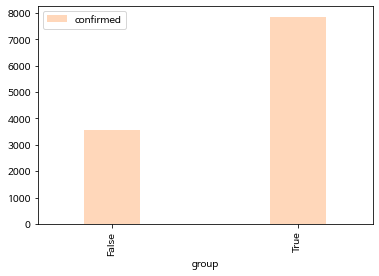

In [48]:
# make a DataFrame
my_colors = ['#ffd7ba'] 
tmp = pd.DataFrame(case_data.groupby('group').confirmed.sum())
tmp.plot.bar(width=0.3, color=my_colors) 

- 확실히 집단감염이 훨씬 많다. 
- 개인감염 보단 집단감염의 방지를 막는게 맞는 것 처럼 보입니다.

In [8]:
코로나_확진현황.head()

,createDt,deathCnt,decideCnt,seq,stateDt,stateTime,updateDt,accExamCnt,accDefRate
778,2020-01-20 17:00:00.000,0,1,1,20200120,17:00,2021-10-07 10:30:51.51,4,25
777,2020-01-21 09:00:00.000,0,1,2,20200121,09:00,2021-10-07 10:30:51.51,15,6.666666667
776,2020-01-22 12:00:00.000,0,1,3,20200122,12:00,2021-10-07 10:30:51.51,21,4.761904762
775,2020-01-23 09:00:00.000,0,1,4,20200123,09:00,2021-10-07 10:30:51.51,25,4
774,2020-01-24 00:00:00.000,0,2,5,20200124,00:00,2021-10-07 10:30:51.51,29,6.896551724


- 현재 코로나 데이터입니다. (2020-01~ 현재까지)
- 이걸보니 일일 확진자수를 확인해보고 싶었습니다.
- deathCnt : 사망자 누적수
- decideCnt : 확진자 누적수 


In [13]:
코로나_확진현황 = pd.read_pickle('time.pkl')
코로나_확진현황_1 = 코로나_확진현황.groupby(by='stateDt').sum().reset_index()

stateDt = list(코로나_확진현황_1['stateDt'])
decideCnt = list(코로나_확진현황_1['decideCnt'])
deathCnt = list(코로나_확진현황_1['deathCnt'])

line = Line("대한민국 코로나19 누적현황", "누적 코로나 환자 현황입니다. 스크롤을 줄여 세부사항을 확인해보세요!",width=1000,height=500 )
line.add("누적확진자수(명)", stateDt, decideCnt,  label_color=['red'], is_datazoom_show=True, datazoom_range=[0, 100]
         , mark_point_symbolsize=100, area_opacity=0.6, mark_point_size=40, legend_pos= 'right'
         ,mark_point=['max']
        )
line

In [15]:
line = Line("대한민국 코로나19 누적현황", "누적 코로나 환자 현황입니다. 스크롤을 줄여 세부사항을 확인해보세요!",width=1000,height=500 )
line.add("사망자(명)", stateDt, deathCnt, mark_point_symbolsize=100, area_opacity=0.8, label_color=['black'] , legend_text_size=15, legend_pos= 'right',
         mark_point=['max'],is_datazoom_show=True, datazoom_range=[0, 100])

In [12]:
코로나_확진현황_1['deathCnt']= pd.to_numeric(코로나_확진현황_1['deathCnt'])
death_x = 코로나_확진현황_1["deathCnt"]
코로나_확진현황_1['decideCnt']= pd.to_numeric(코로나_확진현황_1['decideCnt'])
decide_x = 코로나_확진현황_1["decideCnt"]
코로나_확진현황_2 = 코로나_확진현황_1.copy()
확진자 = 코로나_확진현황_2['decideCnt']
today = [1]
for i,j in enumerate(확진자) :
    if i >= 1 :
        one_day = j - 확진자[i-1]
        today.append(one_day)

사망자 = 코로나_확진현황_2['deathCnt']
today_1 = [0]
for i,j in enumerate(사망자) :
    if i >= 1 :
        one_day = j - 사망자[i-1]
        today_1.append(one_day)

코로나_확진현황_2['일별_확진자'] = today
코로나_확진현황_2['일별_사망자'] = today_1

In [16]:
line = Line("대한민국 코로나19 일별현황",'일별 신규로 발생한 코로나환자 현황입니다. 스크롤을 줄여 세부사항을 확인해보세요!',width=850,height=500 )
line.add("확진자(명)", stateDt , 코로나_확진현황_2['일별_확진자'],  label_color=['red'], is_datazoom_show=True, datazoom_range=[0, 100]
         , mark_point_symbolsize=100,  mark_point_size=60 , legend_text_size=15, legend_pos= 'right'
         ,mark_point=['max','min'], mark_line=["average"]
        )
line

In [17]:
line = Line("대한민국 코로나19 일별 사망자 현황",'일별 신규로 발생한 코로나 사망자 현황입니다. 스크롤을 줄여 세부사항을 확인해보세요!',width=850,height=500 )

line.add("사망자(명)", stateDt , 코로나_확진현황_2['일별_사망자'],  label_color=['black'], is_datazoom_show=True, datazoom_range=[0, 100]
         , mark_point_symbolsize=100,  mark_point_size=60 , legend_text_size=15, legend_pos= 'right'
         ,mark_point=['max','min'], mark_line=["average"]
        )
line

일일 확진자와 일일 사망자 수가 급격하게 변화합니다.  
코로나 종류의 변이에 따라 바뀐것을 우리는 알고 있습니다.

https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/

https://www.kdca.go.kr/contents.es?mid=a20107020000

![](./전염율.PNG)

- 실제로 변이는 알파 베타 감마 델타 오미크론이 있었습니다.  
- 델타형은 알파형 변이 대비 확산력이 1.6배 오미크론은 확산력이 델타 대비 2배
- 유전자 검사를 통한 변이 구분을 한 데이터가 없기 때문에 데이터를 통해 확산력과 치사율, 연령별 위험도를 변이 확산 시기별로 쪼개서 확인


델타형 
20.10월 인도

오미크론형
21.11 다수국가

델타와 오미크론은 한달 이내에 한국에 상륙한것을 기사로 보아 한달을 추가로 기준으로 나누었습니다.
- 코로나 = 20.01~21.10   
- 델타 = 20.11~ 21.11   
- 오미크론 = 22.01 ~ 현재  



In [19]:
decideCnt = current_corona_data['decideCnt']

In [20]:
dtemp =current_corona_data.copy()
dtemp.set_index("createDt",inplace = True)

In [21]:
dtemp['deathCnt']= pd.to_numeric(dtemp['deathCnt']) #문자로 된 열을 바꿔주는 코드
dtemp["diffDeath"] = dtemp.deathCnt.diff().fillna(0) 
dtemp.head()
diff_death= dtemp["diffDeath"]
diff_death

createDt
2020-01-20 17:00:00.000      0.0
2020-01-21 09:00:00.000      0.0
2020-01-22 12:00:00.000      0.0
2020-01-23 09:00:00.000      0.0
2020-01-24 00:00:00.000      0.0
                           ...  
2022-03-05 09:41:58.429    216.0
2022-03-06 09:40:46.49     161.0
2022-03-07 09:06:07.52     139.0
2022-03-08 08:58:30.75     186.0
2022-03-09 08:57:50.503    158.0
Name: diffDeath, Length: 779, dtype: float64

In [22]:
dtemp

,deathCnt,decideCnt,seq,stateDt,stateTime,updateDt,accExamCnt,accDefRate,diffDeath
createDt,,,,,,,,,
2020-01-20 17:00:00.000,0,1,1,20200120,17:00,2021-10-07 10:30:51.51,4,25,0.0
2020-01-21 09:00:00.000,0,1,2,20200121,09:00,2021-10-07 10:30:51.51,15,6.666666667,0.0
2020-01-22 12:00:00.000,0,1,3,20200122,12:00,2021-10-07 10:30:51.51,21,4.761904762,0.0
2020-01-23 09:00:00.000,0,1,4,20200123,09:00,2021-10-07 10:30:51.51,25,4,0.0
2020-01-24 00:00:00.000,0,2,5,20200124,00:00,2021-10-07 10:30:51.51,29,6.896551724,0.0
...,...,...,...,...,...,...,...,...,...
2022-03-05 09:41:58.429,8796,4212636,808,20220305,00:00,2022-03-06 09:41:13.104,NaN,NaN,216.0
2022-03-06 09:40:46.49,8957,4456261,809,20220306,00:00,2022-03-07 09:06:48.272,NaN,NaN,161.0
2022-03-07 09:06:07.52,9096,4666970,810,20220307,00:00,2022-03-08 08:58:58.236,NaN,NaN,139.0


In [23]:
nomal = current_corona_data[current_corona_data['createDt']<='2020-10-01']

In [24]:
nomal

,createDt,deathCnt,decideCnt,seq,stateDt,stateTime,updateDt,accExamCnt,accDefRate
778,2020-01-20 17:00:00.000,0,1,1,20200120,17:00,2021-10-07 10:30:51.51,4,25
777,2020-01-21 09:00:00.000,0,1,2,20200121,09:00,2021-10-07 10:30:51.51,15,6.666666667
776,2020-01-22 12:00:00.000,0,1,3,20200122,12:00,2021-10-07 10:30:51.51,21,4.761904762
775,2020-01-23 09:00:00.000,0,1,4,20200123,09:00,2021-10-07 10:30:51.51,25,4
774,2020-01-24 00:00:00.000,0,2,5,20200124,00:00,2021-10-07 10:30:51.51,29,6.896551724
...,...,...,...,...,...,...,...,...,...
529,2020-09-26 00:00:00.000,399,23515,251,20200926,00:00,2021-10-07 10:30:51.51,2290345,1.035065456
528,2020-09-27 00:00:00.000,401,23610,252,20200927,00:00,2021-10-07 10:30:51.51,2296517,1.036599742
527,2020-09-28 00:00:00.000,406,23660,253,20200928,00:00,2021-10-07 10:30:51.51,2301303,1.036484609
526,2020-09-29 00:00:00.000,407,23698,254,20200929,00:00,2021-10-07 10:30:51.51,2313044,1.033498649


In [25]:
delta = current_corona_data[(current_corona_data['createDt']>='2020-11-01') &(current_corona_data['createDt']<'2021-12-01')]

In [26]:
delta

,createDt,deathCnt,decideCnt,seq,stateDt,stateTime,updateDt,accExamCnt,accDefRate
493,2020-11-01 00:00:00.000,466,26635,287,20201101,00:00,2021-10-07 10:30:51.51,2630630,1.02214605
492,2020-11-02 00:00:00.000,468,26732,288,20201102,00:00,2021-10-07 10:30:51.51,2636650,1.023772886
491,2020-11-03 00:00:00.000,472,26807,289,20201103,00:00,2021-10-07 10:30:51.51,2649859,1.021591101
490,2020-11-04 00:00:00.000,474,26924,290,20201104,00:00,2021-10-07 10:30:51.51,2662259,1.020620136
489,2020-11-05 00:00:00.000,475,27049,291,20201105,00:00,2021-10-07 10:30:51.51,2673705,1.021239933
...,...,...,...,...,...,...,...,...,...
103,2021-11-26 09:03:03.973,3440,432892,709,20211126,00:00,2021-12-02 09:06:24.138,17056003,NaN
102,2021-11-27 09:32:36.026,3492,436959,710,20211127,00:00,2021-12-02 09:06:37.327,17115754,NaN
101,2021-11-28 08:58:53.394,3548,440884,711,20211128,00:00,2021-12-02 09:06:50.152,17158535,NaN
100,2021-11-29 09:05:16.736,3580,444191,712,20211129,00:00,2021-12-12 08:49:29.039,17200325,NaN


In [27]:
omicron = current_corona_data[(current_corona_data['createDt']>='2022-01-01')]

In [28]:
omicron

,createDt,deathCnt,decideCnt,seq,stateDt,stateTime,updateDt,accExamCnt,accDefRate
67,2022-01-01 09:02:39.218,5625,635243,745,20220101,00:00,2022-01-08 09:40:05.3,19364122,NaN
66,2022-01-02 08:57:24.688,5694,639074,746,20220102,00:00,2022-01-08 09:40:16.808,19456900,NaN
65,2022-01-03 08:58:35.591,5730,642199,747,20220103,00:00,2022-01-08 09:40:28.974,19546883,NaN
64,2022-01-04 09:04:35.476,5781,645220,748,20220104,00:00,2022-01-12 09:09:14.713,19671880,NaN
63,2022-01-05 09:01:59.247,5838,649661,749,20220105,00:00,2022-01-12 09:09:21.324,19778824,NaN
...,...,...,...,...,...,...,...,...,...
4,2022-03-05 09:41:58.429,8796,4212636,808,20220305,00:00,2022-03-06 09:41:13.104,NaN,NaN
3,2022-03-06 09:40:46.49,8957,4456261,809,20220306,00:00,2022-03-07 09:06:48.272,NaN,NaN
2,2022-03-07 09:06:07.52,9096,4666970,810,20220307,00:00,2022-03-08 08:58:58.236,NaN,NaN
1,2022-03-08 08:58:30.75,9282,4869672,811,20220308,00:00,2022-03-09 08:58:41.872,NaN,NaN


In [29]:
nomal_death= nomal[nomal["createDt"]>='2020-09-30']
nomal_death= int(nomal_death.iloc[0]['deathCnt'])

In [30]:
nomal_decide =nomal[nomal["createDt"]>='2020-09-30']
nomal_decide= int(nomal_decide.iloc[0]['decideCnt'])

In [31]:
delta_d = delta[delta["createDt"]>='2021-11-30'] 
a= current_corona_data[(current_corona_data['createDt']>='2020-12-01') &(current_corona_data['createDt']<'2020-12-02')]
a_death= int(a.iloc[0]['deathCnt'])
a_decide= int(a.iloc[0]['decideCnt'])
delta_death = int(delta_d.iloc[0]['deathCnt'])-a_death
delta_decide = int(delta_d.iloc[0]['decideCnt'])-a_decide
print(delta_death)
print(delta_decide)

3098
412572


In [32]:
omicron_d = omicron[omicron["createDt"]>='2022-03-09']
a= current_corona_data[(current_corona_data['createDt']>='2021-11-30') &(current_corona_data['createDt']<'2021-12-01')]
a
omicron_death = int(omicron_d.iloc[0]['deathCnt'])-int(a.iloc[0]['deathCnt'])
omicron_decide = int(omicron_d.iloc[0]['decideCnt'])-int(a.iloc[0]['decideCnt'])
print(omicron_decide)

4764879


In [33]:
nomal_critical= nomal_death/nomal_decide
delta_critical = delta_death/delta_decide
omicron_critical = omicron_death/omicron_decide

death_sum = nomal_death + delta_death + omicron_death
nomal_death_ratio = nomal_death/death_sum
delta_death_ratio = delta_death/death_sum
omicron_death_ratio = omicron_death/death_sum

In [34]:
print(nomal_critical)

0.01734492461467389


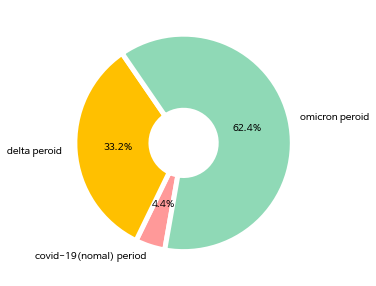

총 사망자 수: 9327
일반 코로나 사망자 수: 413
델타 사망자 수: 3098
오미크론 사망자 수: 5816


In [35]:
ratio = [nomal_death_ratio,delta_death_ratio,omicron_death_ratio]
labels = ['covid-19(nomal) period','delta peroid ','omicron peroid']
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0','gold','silver','cyan','white','pink']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.figure(figsize=(5,5))
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
plt.show()
plt.rc('font', size=10)
print("총 사망자 수:",death_sum)
print ("일반 코로나 사망자 수:",nomal_death )
print("델타 사망자 수:" ,delta_death)
print("오미크론 사망자 수:",omicron_death )

- 오미크론> 델타> 코로나 시기로 사망자가 많다.
- 치사율을 보자

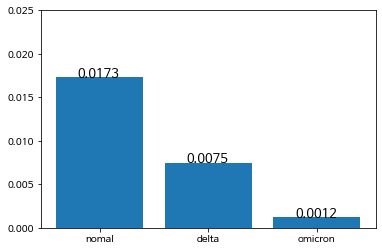

In [36]:
corona = ['nomal', 'delta', 'omicron']
number_of_corona = [nomal_critical, delta_critical, omicron_critical]
for i,covid in enumerate (number_of_corona) : 
    number_of_corona[i]= round(covid,4)

xs = [i for i, _ in enumerate(corona)]
plt.bar(xs, number_of_corona)  # 해당 인덱스에 일치하는 값을 가진, 바 형태 그래프 생성
plt.xticks([i for i, _ in enumerate(corona)], corona )  # x 눈금 및 레이블 설정 
plt.ylim(0, 0.025)  # y 범위 설정 (start, end)
for index, value in enumerate(number_of_corona):
  plt.text(index-0.2, value, str(value),fontsize=13)  # x 좌표, y 좌표, text
plt.show()

- 치사율  = 사망자 / 확진자
- 치사율 nomal  > delta > omicron입니다.
- 치사율 자체도 전체적으로 봤을땐 엄청 낮아보였고 그렇다면 실제로 진짜 큰 위험이 되지 않을까?.
    - 이것을 보니 연령별 치사율과 확진자를 보고싶었다..!


In [37]:
age_sex_data

,confCase,confCaseRate,createDt,criticalRate,death,deathRate,gubun,seq,updateDt
8436,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,0-9,133,2021-10-07 14:17:35.398
8426,8,66.67,2020-02-01 09:00:00.000,0.00,0,0.00,남성,143,2021-10-07 14:17:35.398
8427,4,33.33,2020-02-01 09:00:00.000,0.00,0,0.00,여성,142,2021-10-07 14:17:35.398
8428,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,80 이상,141,2021-10-07 14:17:35.398
8429,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,70-79,140,2021-10-07 14:17:35.398
...,...,...,...,...,...,...,...,...,...
4,821097,16,2022-03-09 09:13:08.946,0,127,1,40-49,15537,null
3,785557,15,2022-03-09 09:13:08.947,0,60,1,30-39,15538,null
2,854612,16,2022-03-09 09:13:08.947,0,22,0,20-29,15539,null
1,716737,14,2022-03-09 09:13:08.947,0,2,0,10-19,15540,null


- 성별과 나이가 있는 데이터입니다.


In [38]:
nomal_age_sex = age_sex_data[age_sex_data['createDt']<='2020-10-01']
detla_age_sex = age_sex_data[(age_sex_data["createDt"]>='2020-11-01') &(age_sex_data['createDt']<'2021-12-01')]
omicron_age_sex =  age_sex_data[age_sex_data['createDt']>='2021-12-01']

nomal_age_sex

,confCase,confCaseRate,createDt,criticalRate,death,deathRate,gubun,seq,updateDt
8436,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,0-9,133,2021-10-07 14:17:35.398
8426,8,66.67,2020-02-01 09:00:00.000,0.00,0,0.00,남성,143,2021-10-07 14:17:35.398
8427,4,33.33,2020-02-01 09:00:00.000,0.00,0,0.00,여성,142,2021-10-07 14:17:35.398
8428,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,80 이상,141,2021-10-07 14:17:35.398
8429,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,70-79,140,2021-10-07 14:17:35.398
...,...,...,...,...,...,...,...,...,...
5770,3178,13.35,2020-09-30 09:00:00.000,0.13,4,0.97,40-49,2799,2021-10-07 14:17:35.398
5771,2908,12.21,2020-09-30 09:00:00.000,0.07,2,0.48,30-39,2798,2021-10-07 14:17:35.398
5772,4762,20.00,2020-09-30 09:00:00.000,0.00,0,0.00,20-29,2797,2021-10-07 14:17:35.398
5773,1306,5.48,2020-09-30 09:00:00.000,0.00,0,0.00,10-19,2796,2021-10-07 14:17:35.398


In [39]:
detla_age_sex

,confCase,confCaseRate,createDt,criticalRate,death,deathRate,gubun,seq,updateDt
5412,12412,46.60,2020-11-01 09:00:00.000,2.01,249,53.43,남성,3157,2021-10-07 14:17:35.398
5414,1153,4.33,2020-11-01 09:00:00.000,20.29,234,50.21,80 이상,3155,2021-10-07 14:17:35.398
5415,2122,7.97,2020-11-01 09:00:00.000,7.16,152,32.62,70-79,3154,2021-10-07 14:17:35.398
5416,4223,15.86,2020-11-01 09:00:00.000,1.26,53,11.37,60-69,3153,2021-10-07 14:17:35.398
5413,14223,53.40,2020-11-01 09:00:00.000,1.53,217,46.57,여성,3156,2021-10-07 14:17:35.398
...,...,...,...,...,...,...,...,...,...
1089,28353,6.34,2021-11-30 14:09:05.58,0.00,1,0.03,0-9,13275,null
1090,43570,9.74,2021-11-30 14:09:05.58,0.00,0,0.00,10-19,13274,null
1093,67719,15.14,2021-11-30 14:09:05.58,0.08,51,1.41,40-49,13271,null
1092,68436,15.30,2021-11-30 14:09:05.58,0.04,26,0.72,30-39,13272,null


In [40]:
omicron_age_sex

,confCase,confCaseRate,createDt,criticalRate,death,deathRate,gubun,seq,updateDt
1088,238649,52.76,2021-12-01 14:08:27.159,0.78,1872,51.19,남성,13287,2021-12-01 18:01:17.526
1087,213701,47.24,2021-12-01 14:08:27.159,0.84,1786,48.81,여성,13288,null
1082,68303,15.10,2021-12-01 14:08:27.16,0.07,51,1.39,40-49,13293,null
1083,67923,15.02,2021-12-01 14:08:27.16,0.30,204,5.58,50-59,13292,null
1085,25359,5.61,2021-12-01 14:08:27.16,3.85,976,26.68,70-79,13290,2021-12-01 18:01:44.609
...,...,...,...,...,...,...,...,...,...
4,821097,16,2022-03-09 09:13:08.946,0,127,1,40-49,15537,null
3,785557,15,2022-03-09 09:13:08.947,0,60,1,30-39,15538,null
2,854612,16,2022-03-09 09:13:08.947,0,22,0,20-29,15539,null
1,716737,14,2022-03-09 09:13:08.947,0,2,0,10-19,15540,null


In [41]:
nomal_age_sex

,confCase,confCaseRate,createDt,criticalRate,death,deathRate,gubun,seq,updateDt
8436,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,0-9,133,2021-10-07 14:17:35.398
8426,8,66.67,2020-02-01 09:00:00.000,0.00,0,0.00,남성,143,2021-10-07 14:17:35.398
8427,4,33.33,2020-02-01 09:00:00.000,0.00,0,0.00,여성,142,2021-10-07 14:17:35.398
8428,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,80 이상,141,2021-10-07 14:17:35.398
8429,0,0.00,2020-02-01 09:00:00.000,0.00,0,0.00,70-79,140,2021-10-07 14:17:35.398
...,...,...,...,...,...,...,...,...,...
5770,3178,13.35,2020-09-30 09:00:00.000,0.13,4,0.97,40-49,2799,2021-10-07 14:17:35.398
5771,2908,12.21,2020-09-30 09:00:00.000,0.07,2,0.48,30-39,2798,2021-10-07 14:17:35.398
5772,4762,20.00,2020-09-30 09:00:00.000,0.00,0,0.00,20-29,2797,2021-10-07 14:17:35.398
5773,1306,5.48,2020-09-30 09:00:00.000,0.00,0,0.00,10-19,2796,2021-10-07 14:17:35.398


In [42]:
nomal_age_sex_d = nomal_age_sex[ nomal_age_sex["createDt"]>='2020-09-30']
nomal_age_sex_d

,confCase,confCaseRate,createDt,criticalRate,death,deathRate,gubun,seq,updateDt
5767,1906,8.00,2020-09-30 09:00:00.000,7.14,136,32.93,70-79,2802,2021-10-07 14:17:35.398
5764,10964,46.05,2020-09-30 09:00:00.000,1.98,217,52.54,남성,2805,2021-10-07 14:17:35.398
5765,12847,53.95,2020-09-30 09:00:00.000,1.53,196,47.46,여성,2804,2021-10-07 14:17:35.398
5766,971,4.08,2020-09-30 09:00:00.000,21.42,208,50.36,80 이상,2803,2021-10-07 14:17:35.398
5768,3781,15.88,2020-09-30 09:00:00.000,1.16,44,10.65,60-69,2801,2021-10-07 14:17:35.398
5774,578,2.43,2020-09-30 09:00:00.000,0.00,0,0.00,0-9,2795,2021-10-07 14:17:35.398
5770,3178,13.35,2020-09-30 09:00:00.000,0.13,4,0.97,40-49,2799,2021-10-07 14:17:35.398
5771,2908,12.21,2020-09-30 09:00:00.000,0.07,2,0.48,30-39,2798,2021-10-07 14:17:35.398
5772,4762,20.00,2020-09-30 09:00:00.000,0.00,0,0.00,20-29,2797,2021-10-07 14:17:35.398
5773,1306,5.48,2020-09-30 09:00:00.000,0.00,0,0.00,10-19,2796,2021-10-07 14:17:35.398


In [43]:
nomal_age_sex_d = nomal_age_sex_d.sort_values(by=['gubun'], axis=0)
nomal_age_sex_d.set_index("gubun",inplace = True)

In [44]:
result_nomal = nomal_age_sex_d[["confCase","death"]]
reslut_nomal = result_nomal.apply(pd.to_numeric)
result_nomal = result_nomal.drop(['남성','여성'])
result_nomal = result_nomal.apply(pd.to_numeric)

In [45]:
result_nomal

,confCase,death
gubun,,
0-9,578,0
10-19,1306,0
20-29,4762,0
30-39,2908,2
40-49,3178,4
50-59,4421,19
60-69,3781,44
70-79,1906,136
80 이상,971,208


일반 코로나 시점 연령별 확진확률과 사망률 
- 50~60대 이상부터는 확실히 치사율이 높다.

In [48]:
delta_age_sex_d = detla_age_sex[detla_age_sex["createDt"]>='2021-11-30'] 
a= age_sex_data[(age_sex_data['createDt']>='2020-12-01') &(age_sex_data['createDt']<'2020-12-02')]

In [49]:
a

,confCase,confCaseRate,createDt,criticalRate,death,deathRate,gubun,seq,updateDt
5082,16554,47.77,2020-12-01 09:00:00.000,1.67,276,52.17,남성,3487,2021-10-07 14:17:35.398
5083,18096,52.23,2020-12-01 09:00:00.000,1.40,253,47.83,여성,3486,2021-10-07 14:17:35.398
5084,1449,4.18,2020-12-01 09:00:00.000,18.15,263,49.72,80 이상,3485,2021-10-07 14:17:35.398
5085,2650,7.65,2020-12-01 09:00:00.000,6.45,171,32.33,70-79,3484,2021-10-07 14:17:35.398
5086,5282,15.24,2020-12-01 09:00:00.000,1.21,64,12.10,60-69,3483,2021-10-07 14:17:35.398
5088,4859,14.02,2020-12-01 09:00:00.000,0.10,5,0.95,40-49,3481,2021-10-07 14:17:35.398
5089,4447,12.83,2020-12-01 09:00:00.000,0.04,2,0.38,30-39,3480,2021-10-07 14:17:35.398
5090,6546,18.89,2020-12-01 09:00:00.000,0.00,0,0.00,20-29,3479,2021-10-07 14:17:35.398
5091,2096,6.05,2020-12-01 09:00:00.000,0.00,0,0.00,10-19,3478,2021-10-07 14:17:35.398
5092,1008,2.91,2020-12-01 09:00:00.000,0.00,0,0.00,0-9,3477,2021-10-07 14:17:35.398


In [50]:
a =a.sort_values(by=['gubun'], axis=0)
a.set_index("gubun",inplace = True)

In [51]:
tmp_a = a[["confCase","death"]]
tmp_a =tmp_a.apply(pd.to_numeric)
tmp_a = tmp_a.drop(['남성','여성'])

In [52]:
delta_age_sex_d = delta_age_sex_d.sort_values(by=['gubun'], axis=0)
delta_age_sex_d.set_index("gubun",inplace = True)

In [53]:
tmp = delta_age_sex_d[["confCase","death"]]
tmp = tmp.apply(pd.to_numeric)
tmp = tmp.drop(['남성','여성'])

In [54]:
result_delta = tmp.sub(tmp_a)
print(result_delta)

       confCase  death
gubun                 
0-9       27345      1
10-19     41474      0
20-29     69705     12
30-39     63989     24
40-49     62860     46
50-59     60888    180
60-69     51363    458
70-79     22185    797
80 이상     12771   1577


- 델타의 사망률은 

In [57]:
omicron_age_sex_d = omicron_age_sex[omicron_age_sex["createDt"]>='2022-03-09'] 
a= age_sex_data[(age_sex_data['createDt']>='2021-12-31') &(age_sex_data['createDt']<'2022-01-01')]

a =a.sort_values(by=['gubun'], axis=0)
a.set_index("gubun",inplace = True)

tmp_a = a[["confCase","death"]]
tmp_a =tmp_a.apply(pd.to_numeric)
tmp_a = tmp_a.drop(['남성','여성'])

omicron_age_sex_d  = omicron_age_sex_d.sort_values(by=['gubun'], axis=0)
omicron_age_sex_d.set_index("gubun",inplace = True)

tmp = omicron_age_sex_d [["confCase","death"]]
tmp = tmp.apply(pd.to_numeric)
tmp = tmp.drop(['남성','여성'])

result_omicron = tmp.sub(tmp_a)
print(result_omicron)

       confCase  death
gubun                 
0-9      582848      2
10-19    653684      2
20-29    760169     10
30-39    693858     25
40-49    728951     50
50-59    527604    157
60-69    381514    479
70-79    152583    928
80 이상    100069   2224


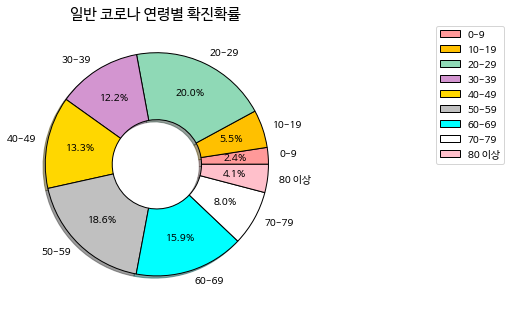

In [46]:
wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor': 'black'}
plt.figure(figsize=(5,10))
plt.pie(result_nomal['confCase'], labels = result_nomal['confCase'].index, autopct = '%.1f%%', colors = colors, shadow = True, wedgeprops = wedgeprops, pctdistance=0.7)
plt.title('일반 코로나 연령별 확진확률 ', size = 15)
plt.legend(loc = (1.5, 0.5))
plt.show()

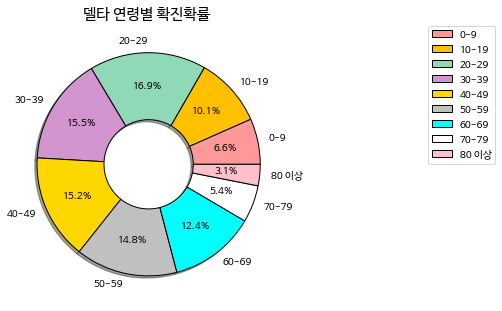

In [55]:
wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor': 'black'}
plt.figure(figsize=(5,10))
plt.pie(result_delta['confCase'], labels = result_delta['confCase'].index, autopct = '%.1f%%', colors = colors, shadow = True, wedgeprops = wedgeprops, pctdistance=0.7)
plt.title('델타 연령별 확진확률 ', size = 15)
plt.legend(loc = (1.5, 0.5))
plt.show()

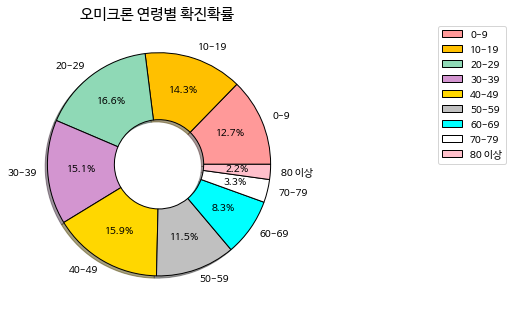

In [58]:
wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor': 'black'}
plt.figure(figsize=(5,10))
plt.pie(result_omicron['confCase'], labels = result_omicron['confCase'].index, autopct = '%.1f%%', colors = colors, shadow = True, wedgeprops = wedgeprops, pctdistance=0.7)
plt.title('오미크론 연령별 확진확률 ', size = 15)
plt.legend(loc=(1.5, 0.5))
plt.show()

- 연령별 확진확률을 확인했을때 오미크론이 0~19세에 아동,청소년 확진확률이 높은 것을 확인 할 수 있습니다.

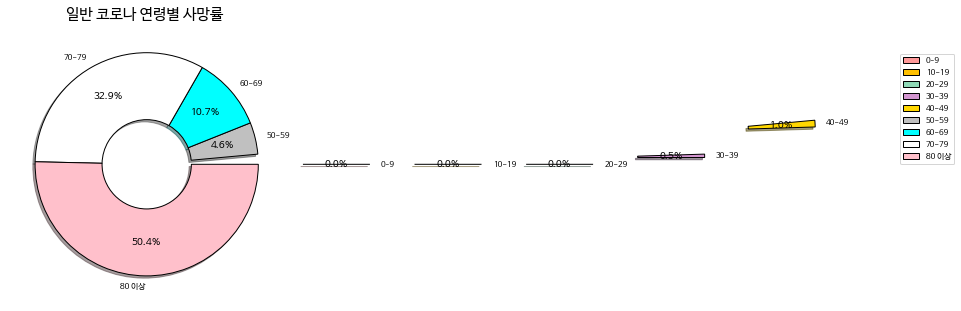

In [231]:
wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor': 'black'}
plt.figure(figsize=(5,10))
plt.pie(result_nomal['death'], labels = result_nomal['death'].index, 
        autopct = '%.1f%%', colors = colors, shadow = True, 
        wedgeprops = wedgeprops, pctdistance=0.7, explode = pd.Series([1, 2, 3, 4, 5,0,0,0,0]))
plt.title('일반 코로나 연령별 사망률 ', size = 15)
plt.legend(loc = (3.2, 0.5))
plt.show()

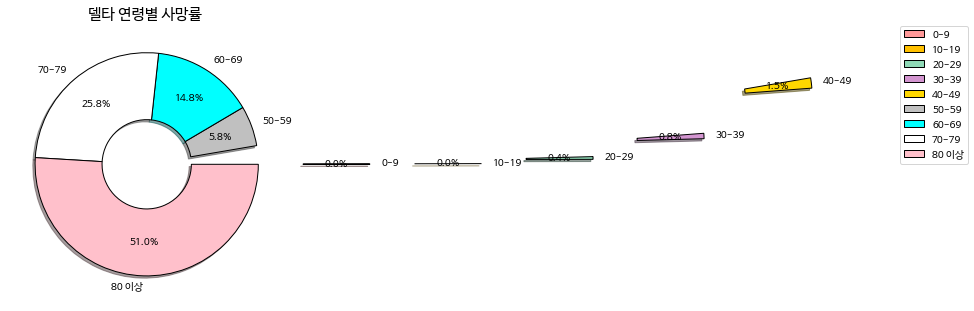

In [59]:
wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor': 'black'}
plt.figure(figsize=(5,10))
plt.pie(result_delta['death'], labels = result_delta['death'].index, 
        autopct = '%.1f%%', colors = colors, shadow = True, 
        wedgeprops = wedgeprops, pctdistance=0.7, explode = pd.Series([1, 2, 3, 4, 5,0,0,0,0]))
plt.title('델타 연령별 사망률 ', size = 15)
plt.legend(loc = (3.2, 0.5))
plt.show()

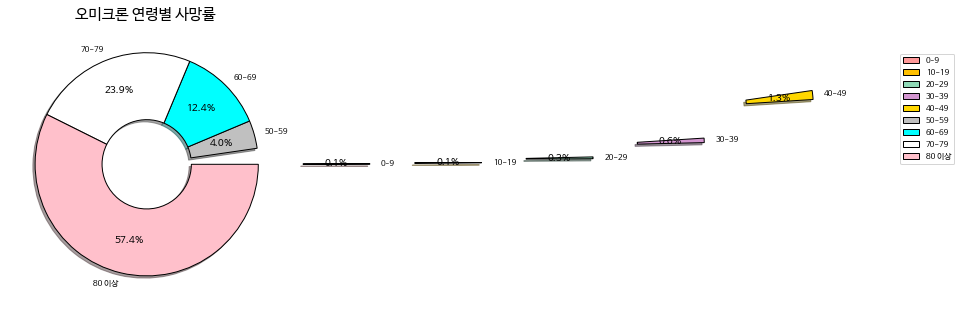

In [250]:
wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor': 'black'}
plt.figure(figsize=(5,10))
plt.pie(result_omicron['death'], labels = result_omicron['death'].index, 
        autopct = '%.1f%%', colors = colors, shadow = True, 
        wedgeprops = wedgeprops, pctdistance=0.7, explode = pd.Series([1, 2, 3, 4, 5,0,0,0,0]))
plt.title('오미크론 연령별 사망률 ', size = 15)
plt.legend(loc = (3.2, 0.5))
plt.show()

- 사망률을 보면 오미크론은 60대 부터 12프로 이상으로 치명적으로 보입니다.
- 아까봤던 0~19세의 확진확률은 올랐지만 사망률은 크게 오르지 않았습니다.

결론 : 학생들의 활동은 재제를 하지 않더라도 노인인구에 대한 활동에 있어 각별한 보호가 필요해보인다.(정책적으로든 개인적으로든)


## 대구 신천지 코로나 이후 대구와 다른지역 비교
- case 데이터의 신천지 사례를 보고든 생각
- 개인적인 생각은 신천지 사건 이 부터 지하철에서 노인분들이 마스크를 많이 끼고 자가 방역에 힘쓴다고 느꼈습니다.
- 그렇다면 실제로 신천지 이후 1년동안  대구는 다른 지역보다 확진세가 낮을까?

In [70]:
shincheonji_case = case_data[case_data['infection_case']=='Shincheonji Church']
shincheonji_case

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
20,1000021,Seoul,from other city,True,Shincheonji Church,8,-,-
39,1100002,Busan,from other city,True,Shincheonji Church,12,-,-
48,1200001,Daegu,Nam-gu,True,Shincheonji Church,4511,35.84008,128.5667
59,1300002,Gwangju,from other city,True,Shincheonji Church,9,-,-
66,1400004,Incheon,from other city,True,Shincheonji Church,2,-,-
75,1500006,Daejeon,from other city,True,Shincheonji Church,2,-,-
80,1600001,Ulsan,from other city,True,Shincheonji Church,16,-,-
86,1700003,Sejong,from other city,True,Shincheonji Church,1,-,-
96,2000007,Gyeonggi-do,from other city,True,Shincheonji Church,29,-,-
112,3000001,Gangwon-do,from other city,True,Shincheonji Church,17,-,-


In [62]:
city_population_data_path = data_path/'인구밀집도.csv'
city_population_data = pd.read_csv(city_population_data_path)

In [63]:
city_population_data

,Unnamed: 0,인구,인구밀도,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,sum,"51,781",516,NaN,NaN,NaN,NaN,NaN,NaN
1,서울,"9,602","15,865",NaN,NaN,NaN,NaN,NaN,NaN
2,부산,"3,344","4,342",NaN,NaN,NaN,NaN,NaN,NaN
3,대구,"2,419","2,738",NaN,NaN,NaN,NaN,NaN,NaN
4,인천,"2,951","2,770",NaN,NaN,NaN,NaN,NaN,NaN
5,광주,"1,488","2,969",NaN,NaN,NaN,NaN,NaN,NaN
6,대전,"1,500","2,780",NaN,NaN,NaN,NaN,NaN,NaN
7,울산,"1,140","1,073",NaN,NaN,NaN,NaN,NaN,NaN
8,세종,349,750,NaN,NaN,NaN,NaN,NaN,NaN
9,경기,"13,405","1,315",NaN,NaN,NaN,NaN,NaN,NaN


- city_population_data = 인구밀집도.csv' (https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007)
- 인구 : 명/ 1000명
- 인구 밀도 : 인구수/단위면적

In [64]:
city_population_data= city_population_data.rename(columns={'Unnamed: 0':'지역'})
city_population_data.set_index('지역',inplace = True)

In [65]:
city_population_data =city_population_data.drop(columns=['Unnamed: 3', 'Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8'], axis=1)

In [66]:
city_population_data

,인구,인구밀도
지역,,
sum,"51,781",516
서울,"9,602","15,865"
부산,"3,344","4,342"
대구,"2,419","2,738"
인천,"2,951","2,770"
광주,"1,488","2,969"
대전,"1,500","2,780"
울산,"1,140","1,073"
세종,349,750


In [67]:
city_population_data['인구'] = city_population_data['인구'].str.replace(',','')
city_population_data['인구밀도'] = city_population_data['인구밀도'].str.replace(',','')
city_population_data['인구'] = city_population_data['인구'].apply(pd.to_numeric)
city_population_data['인구밀도'] = city_population_data['인구밀도'].apply(pd.to_numeric)

city_population_data

,인구,인구밀도
지역,,
sum,51781,516
서울,9602,15865
부산,3344,4342
대구,2419,2738
인천,2951,2770
광주,1488,2969
대전,1500,2780
울산,1140,1073
세종,349,750


<AxesSubplot:xlabel='지역'>

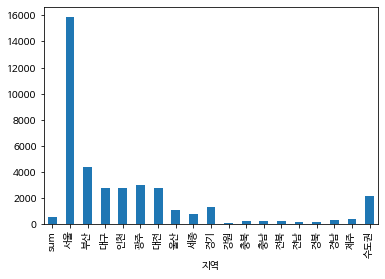

In [68]:
city_population_data['인구밀도'].plot.bar()

- 대구 인천 광주 대전 울산을  비교하면 되겠다.

- 신천지 확진자는 2월, 2달간의 간격을 두고 확인을 해보기로 했습니다.  
https://ko.wikipedia.org/wiki/%EB%8C%80%EA%B5%AC%EA%B4%91%EC%97%AD%EC%8B%9C%EC%9D%98_%EC%BD%94%EB%A1%9C%EB%82%9819_%EB%B2%94%EC%9C%A0%ED%96%89#cite_note-2
- 4월부터 1년동안의 도시들의 확진자수 비교를 해보자

In [78]:
city_data_2 = city_data[(city_data['createDt']>='2020-05-01')&(city_data['createDt']<='2021-05-01')]
city_data_2.head(12)
city_data_2['deathCnt']= city_data_2['deathCnt'].apply(pd.to_numeric)
city_data_2['defCnt']=city_data_2['defCnt'].apply(pd.to_numeric)
city_data_2.set_index("stdDay",inplace = True)
city_data_2

,createDt,deathCnt,defCnt,gubun,gubunCn,gubunEn,incDec,localOccCnt,overFlowCnt,qurRate,seq,updateDt,isolClearCnt
stdDay,,,,,,,,,,,,,
2020년 05월 01일 00시,2020-05-01 09:00:00.000,0,30,광주,光州,Gwangju,0,0,0,2.06,1952,2021-09-16 10:11:33.897,27
2020년 05월 01일 00시,2020-05-01 09:00:00.000,0,40,대전,大田,Daejeon,0,0,0,2.71,1951,2021-09-16 10:11:33.897,34
2020년 05월 01일 00시,2020-05-01 09:00:00.000,0,94,인천,仁川,Incheon,1,0,1,3.18,1953,2021-09-16 10:11:33.897,66
2020년 05월 01일 00시,2020-05-01 09:00:00.000,1,43,울산,蔚山,Ulsan,0,0,0,3.75,1950,2021-09-16 10:11:33.897,35
2020년 05월 01일 00시,2020-05-01 09:00:00.000,3,137,부산,釜山,Busan,0,0,0,4.02,1955,2021-09-16 10:11:33.897,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021년 04월 30일 00시,2021-04-30 09:00:00.000,10,1053,전남,全南,Jeollanam-do,5,5,0,56.47,8859,2021-09-16 10:11:33.897,963
2021년 04월 30일 00시,2021-04-30 09:00:00.000,78,4110,경북,庆北,Gyeongsangbuk-do,29,28,1,154.37,8858,2021-09-16 10:11:33.897,3738
2021년 04월 30일 00시,2021-04-30 09:00:00.000,17,3915,경남,庆南,Gyeongsangnam-do,37,37,0,116.47,8857,2021-09-16 10:11:33.897,3400


In [79]:
seoul_data = city_data_2[city_data_2['gubun']=="서울"]
deagu_data = city_data_2[city_data_2['gubun'] =="대구"]
incheon_data = city_data_2[city_data_2['gubun'] =="인천"]
gwangju_data = city_data_2[city_data_2['gubun'] =="광주"]
deajeon_data = city_data_2[city_data_2['gubun'] =="대전"]
ulsan_data = city_data_2[city_data_2['gubun']=='울산']


In [80]:
deagu_data["diffDef"] = deagu_data.defCnt.diff().fillna(0)

In [81]:
deagu_data["diffDef"] = deagu_data.defCnt.diff().fillna(0)
seoul_data["diffDef"]= seoul_data.defCnt.diff().fillna(0)
incheon_data["diffDef"]= incheon_data.defCnt.diff().fillna(0)
gwangju_data["diffDef"]=gwangju_data.defCnt.diff().fillna(0)
deajeon_data["diffDef"]=deajeon_data.defCnt.diff().fillna(0)
ulsan_data["diffDef"]=ulsan_data.defCnt.diff().fillna(0)


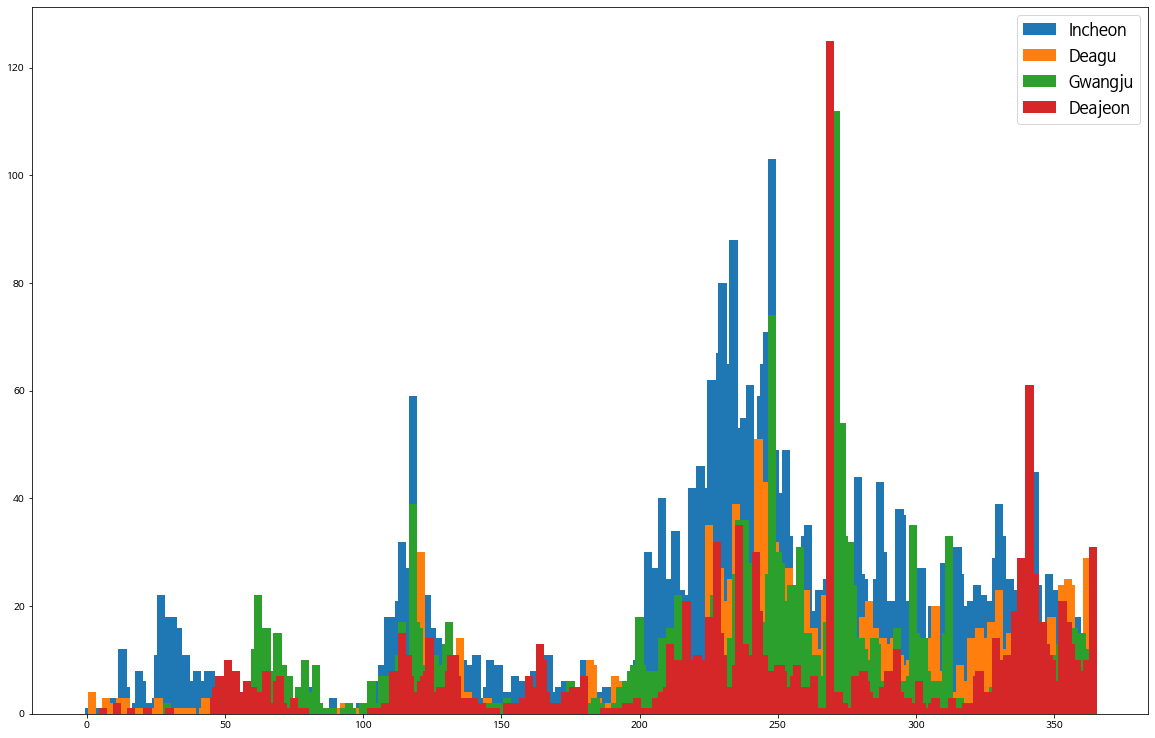

In [82]:
plt.figure(figsize=(20,13))
tmp_index = list(deagu_data.index)
x_range = range(len(tmp_index))
plt.bar(x_range,incheon_data['diffDef'], width = 3, label='Incheon')
plt.bar(x_range,deagu_data['diffDef'],width =3,label='Deagu')
plt.bar(x_range,gwangju_data['diffDef'],width =3,label='Gwangju')
plt.bar(x_range,deajeon_data['diffDef'],width =3,label='Deajeon')
plt.rc('legend', fontsize=16)
plt.legend()
plt.show()


- 인구 밀집도가 비슷한 인천 대구 광주 대전을 뽑았다.
- 이 도시들은 정책또한 서울과 달리 비슷하게 진행되었다. (거리두기)
- 한눈에 봤을땐 대구와 비교가 힘들다


In [88]:
deagu_mean = deagu_data['diffDef'].mean()
incheon_mean = incheon_data['diffDef'].mean()
gwangju_mean = gwangju_data['diffDef'].mean()
deajeon_mean = deajeon_data['diffDef'].mean()

city_mean = [deagu_mean, incheon_mean,gwangju_mean,deajeon_mean]
print(city_mean)

[6.846575342465753, 15.263013698630138, 6.517808219178082, 4.63013698630137]


In [92]:
deagu_sum = deagu_data['diffDef'].sum()
incheon_sum = incheon_data['diffDef'].sum()
gwangju_sum = gwangju_data['diffDef'].sum()
deajeon_sum = deajeon_data['diffDef'].sum()

city_sum = [deagu_sum, incheon_sum,gwangju_sum,deajeon_sum]
print(city_sum)

[2499.0, 5571.0, 2379.0, 1690.0]


- 평균과 총합으로 확인해보자
- 지도를 이용하여 히트맵을 만들어 비교해보기로함

In [111]:
location = []
location.append([35.828813, 128.565498]) #대구
location.append([37.474650, 126.714649])#인천
location.append([35.159703, 126.842733])#광주
location.append([36.335199, 127.398288])#대전

In [93]:
location_sum = []

for loc,num in zip(location,city_sum) :
    loc.append(num)
    location_sum.append(loc)

location_sum

[[35.828813, 128.565498, 2499.0],
 [37.47465, 126.714649, 5571.0],
 [35.159703, 126.842733, 2379.0],
 [36.335199, 127.398288, 1690.0]]

In [112]:
location_mean = []    
for loc,num in zip(location,city_mean) :
    loc.append(num)
    location_mean.append(loc)
location_mean    



[[35.828813, 128.565498, 6.846575342465753],
 [37.47465, 126.714649, 15.263013698630138],
 [35.159703, 126.842733, 6.517808219178082],
 [36.335199, 127.398288, 4.63013698630137]]

In [103]:
from folium.plugins import HeatMap
latitude, longitude = 35.9078, 127.7669 #대한민국 위도, 경도
s_korea = folium.Map(location = [latitude, longitude], zoom_start=7)
HeatMap(location_sum,radius=100).add_to(s_korea)
s_korea

In [109]:
m_korea = folium.Map(location = [latitude, longitude], zoom_start=5)
HeatMap(location_mean).add_to(m_korea)
m_korea

In [113]:
del(location_mean[1]) #인천은 빼자
del(location_sum[1])

In [114]:
m_korea = folium.Map(location = [latitude, longitude], zoom_start=8)
HeatMap(location_mean,radius=100).add_to(m_korea)
m_korea

- 인구밀도와 대구로 비교했을때 가장 확진자가 적은곳은 대전이였다.. 
- 결론 : 신천지 사건이 인식의 변화를 일으켜 확진자 수를 줄게 하지 않을까라는 생각을 했지만 똑같았다..

In [116]:
sex_df = pd.read_pickle('./sex.pkl')
time_df = pd.read_pickle('./time.pkl')
region_df = pd.read_pickle('./region.pkl') 
from matplotlib import font_manager, rc
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
font = font_manager.FontProperties(fname=font_path). get_name()
rc('font', family=font)

plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams["font.family"] = 'nanummyeongjo'
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False


## 국내외 주요 경제지표와 코로나의 상관관계
## 원달러 현황

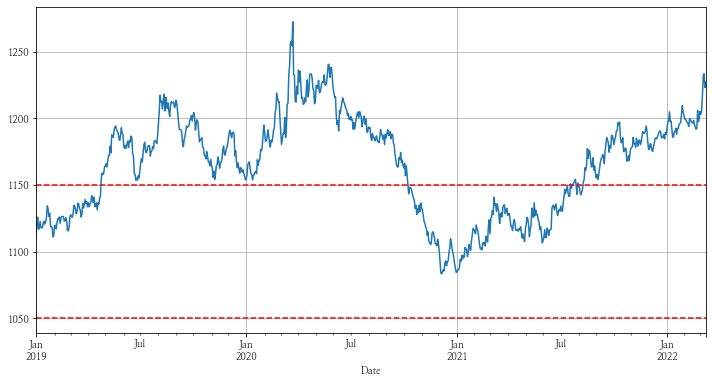

In [117]:
#원달라 환율
USD_KRX = fdr.DataReader('USD/KRW', start='2019-01-01')#미국 달러/한국 원(원달러)

graph = USD_KRX.loc[:,'Close'].plot()
graph.axhline(1050, ls='--', color='r')#1050선
graph.axhline(1150, ls='--', color='r')#1150선

- 첫번째로 원달러환율은 우리나라 증시에 가장 중요한 지표라고 할 수 있다. 원달러환율이 코로나 펜데믹 선언이후에 이전에 비해 환율이 급상승 한 것을 알 수 있다. 이는 사람들이 위기 상황으로 인식해 안전자산으로 몰리는 상황임을 알 수 있다.

- 또한 최근 환율이 급증하는데 이는 러시아의 우크라이나 침공이 장기화되면서 원유가격상승에 대한 압박으로 인해 비롯된 것으로 보인다.

이로 알 수 있는것은 국제사회가 위기 상황일때 환율은 상승하는 것을 알 수 있다.

## 미국 국채금리

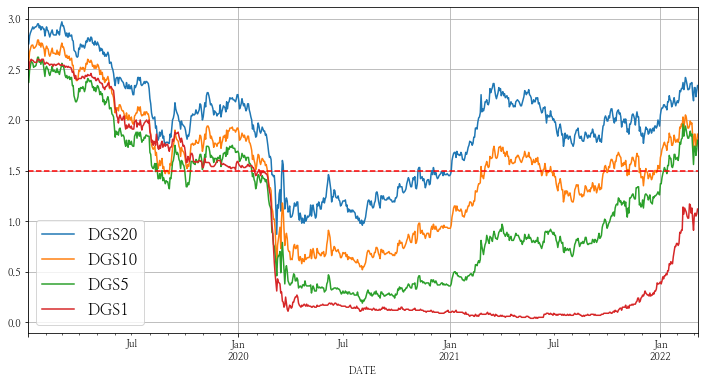

In [121]:
#미국 국채 금리(20년, 10년, 5년, 1년)
DGS = fdr.DataReader(['DGS20','DGS10','DGS5','DGS1'], start='2019-01-01', data_source='fred') 
graph= DGS.plot()
graph.axhline(1.5, ls='--', color='r')

- 미국 국채금리의 하락은 곧 미국 국채가격의 상승을 의미하게 된다. 코로나의 유행을 알린 펜데믹 선언이후 미국 국채금리가 급락하는 것을 볼 수 있다. 이를 통해 사람들의 심리가 안전자산으로 향하고 있음을 알 수 있다.

- 최근 러시아의 우크라이나 원전 장악으로 인해 국채금리가 급락하고 있다고 한다. 

## 미국 장단기 금리차

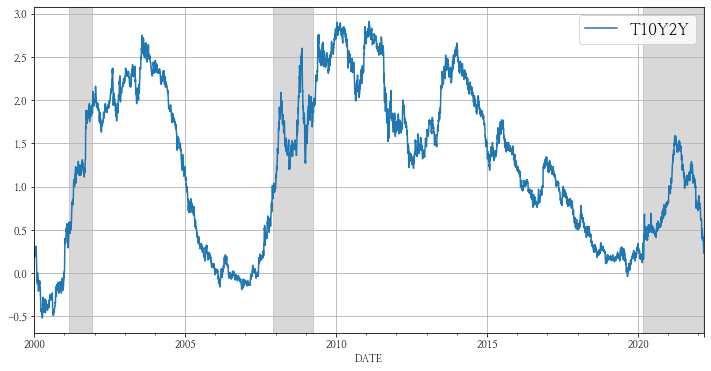

In [120]:
#미국 장단기 금리차
T10Y2Y = fdr.DataReader('T10Y2Y', start='2000-01-01', data_source='fred') #미국 장단기 금리차
graph= T10Y2Y.plot()
graph.axvspan('2001-03-01', '2001-12-01', color='gray', alpha=0.3)
graph.axvspan('2007-12-01', '2009-03-30', color='gray', alpha=0.3)
graph.axvspan('2020-03-01', '2022-03-01', color='gray', alpha=0.3)

- 미국장단기 금리차는 많은 정보를 담고 있다. 미국장단기 금리가 역전되거나 둘이 만나게 되면 경제위기가 찾아오곤 했다. 00년 이후 IT버블이 터지고 07년이후 금융위기가 왔으며 20년이후 코로나침체가 오는 것을 알 수 있다.

여기서 흥미로운 점을 발견할 수 있다. 통상적으로 10년 내외로 미국장단기 금리차가 역전되고 경제위기가 찾아왔다.

## 변동성 지수(VIX)

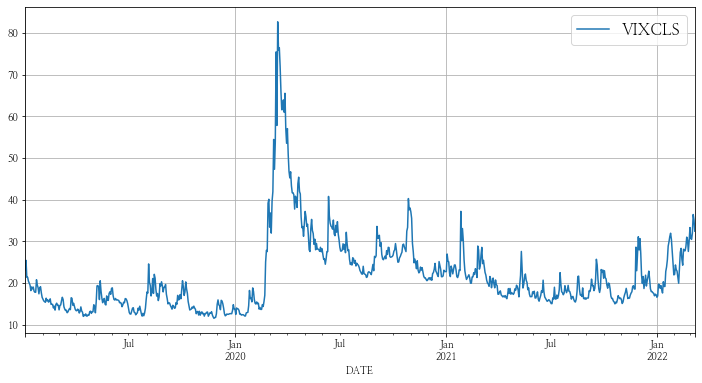

In [122]:
#VIX(변동성 지수)
VIX = fdr.DataReader('VIXCLS', start='2019-01-01', data_source='fred')#VIX(변동성 지수)
graph= VIX.plot()

- 빅스지수란 주가가 상승 하락하며 주가가 요동치는 것을 의미한다.

- 통상적으로 주식시장이 상승할때는 불안해하지 않는다. 하지만 하락할 땐 불안해한다. 하락장에서 보다 예민해진다는 의미다. 이러한 영향 떄문인지 빅스지수는 주식시장이 하락하는 시기에 좀 더 민감하게 반응한다. 미국주식시장이 급락하게 된다면 빅시지수가 큰 폭으로 상승하게 된다. 변동성을 다른말로 바꾸면 공포감이 된다. 그래서 빅스지수를 공포지수라고 부르기도 한다. 

코로나로 인해 미국증시가 급락해 변동지수가 급등하는 것을 볼 수 있다.

## TED Spread

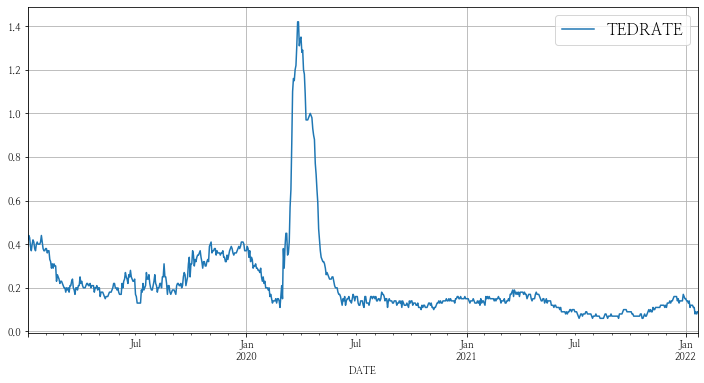

In [123]:
#TED Spread
TEDRATE = fdr.DataReader('TEDRATE', start='2019-01-01',data_source='fred')#TED Spread
graph=TEDRATE.plot()

- TED Spread는 미국 단기국채 T와 ED가 의미하는 대외 거래 금리인 리보금리의 차이를 말한다.

- TED Spread는 흔히 경기 선행지표를 의미하는데 경제 상황이 악화되면 채무자들은 자금을 급히 구해야 하고 이런 경우 수요 증가로 리보금리는 상승하게 된다. 이에 반해 투자자들은 미국 단기 채권은 안정성이 보장되기에 경제 상황이 악화되면 채권으로 몰리게 되고 금리는 낮아지게 된다.

- TED Spread가 상승하면 유동성이 부족해 자금 경색이 일어난다( 리보금리가 상승하면서 금리가 비싸 돈을 빌리기 어렵고 채권으로 돈이 몰린다)

- 다른 지표들과 마찬가지로 코로나 상황에 TED Spread가 증가한 것을 알 수 있따. 이는 미국 단기국채 금리는 낮아졌고 리보금리는 높아졌다는 것을 알 수 있다.

## 금융스트레스 지수

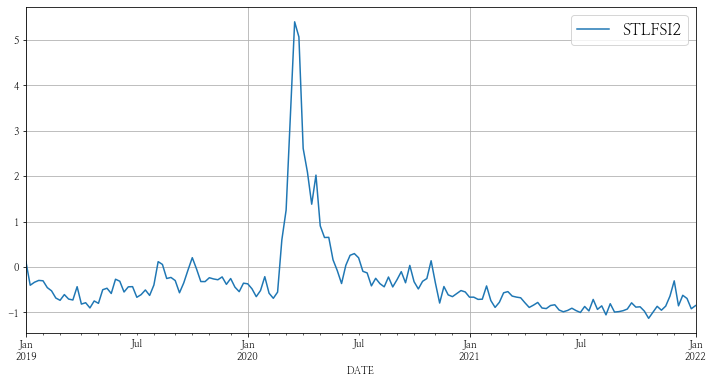

In [124]:
#금융스트레스 지수
STLFSI2 = fdr.DataReader('STLFSI2', start='2019-01-01',data_source='fred')#금융스트레스 지수
graph=STLFSI2.plot()

- 투자자 및 금융기관들은 투자를 할 때 위험이 있다고 생각하면 스트레스가 높아지는데 이를 숫자로 표현한 지표

- 2020년에 상승하는 걸 볼 수있음.

## 결론

코로나 상황이나 위기 상황일때 국내외 주요지표들이 변동이 심한걸 알 수 있었다. 하지만 최근 러시아의 우크라이나 침공이 장기화 됨에 따라 불안한 지표도 있었지만 코로나 펜데믹 선언이후 지속적으로 변동성이 적은걸 알 수 있다. 이는 코로나가 사람들의 인식에서 위험성이 적어짐을 의미한다고 본다. 하지만 국내에서는 오미코론 변이로 인해 코로나 확진이 증가하는 추세고 사망자 또한 많이 나오는 것으로 보이나 확진자 대비 사망자는 오히려 줄어든 모습을 볼 수 있었다. 이는 더 이상 코로나가 심각한 질병이 아닌 전염성이 강한 감기 정도로 치부해야 하지 않을까 생각한다.